In [1]:
import sys
sys.path.append("../src/")

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
%matplotlib inline

In [3]:
import data_loader as dl
from draw import DRAW

Using TensorFlow backend.


In [4]:
x_full, x_labeled, y = dl.load_simulated("128")
#(x_full, _), (x_labeled, y) = tf.keras.datasets.mnist.load_data()
y = y if len(y.shape) == 1 else y.argmax(1)
#x_full = np.expand_dims(x_full, -1)/ 255
#x_labeled = np.expand_dims(x_labeled, -1)/ 255

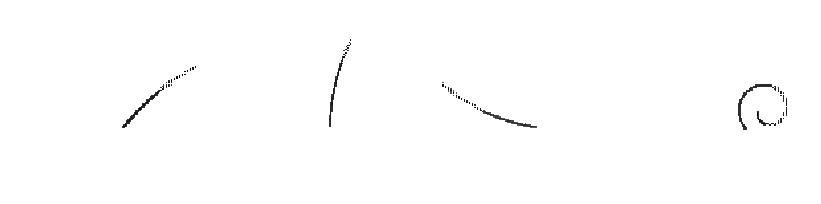

In [5]:
"""
The data comes in the form of images, we'll display a couple for clarity
"""
%matplotlib inline
fig, axs = plt.subplots(ncols=4, figsize=(14, 5))
og_events = [x_full[i].reshape(x_full[i].shape[0], x_full[i].shape[1]) for i in range(4)]
[axs[i].imshow(og_events[i], cmap="Greys") for i in range(4)]
[axs[i].axis("off") for i in range(4)]
plt.show()

In [6]:
T = 6
enc_size = 400
dec_size = 400
latent_dim = 2

delta = 0.8
N = 55

delta_write = delta
delta_read = delta

read_N = N
write_N = N

attn_config = {
    "read_N": read_N,
    "write_N": write_N,
    "write_N_sq": write_N ** 2,
    "delta_w": delta_write,
    "delta_r": delta_read,
}

mode_config = {
    "simulated_mode":False, #deprecated, to be removed
    "restore_mode":False, #indicates whether to load weights 
    "include_KL":False, #whether to compute the KL loss over the latent space
    "include_MMD":True, #same as above, but MMD 
    "include_KM":False, #same as above, but K-means. See thesis for a more in-depth treatment of these
    "batchnorm":False, #whether to include batch-normalization between layers
    "use_vgg":False, #whether the input data is from a pre-trained model 
    "use_dd":False, #whether to use the dueling-decoder objective 
}

model = DRAW(
    T,
    dec_size,
    enc_size,
    latent_dim,
    x_full,
    beta=1,
    attn_config=attn_config,
    mode_config=mode_config
)

In [7]:
graph_kwds = {
    "activation": "lrelu",
    "output_activation": "sigmoid",
    "kernel_reg_strength": 1e-8,
}
loss_kwds = {
    "reconst_loss": None
}
model.compile_model(graph_kwds, loss_kwds)

In [8]:
optimizer = tf.train.AdamOptimizer
opt_args = [1e-5, ] #learning rate
opt_kwargs = {"beta1": 0.8, "beta2":0.99}
model.compute_gradients(optimizer, opt_args, opt_kwargs)

In [9]:
epochs = 200
batch_size = 100
earlystop = True
sess = tf.InteractiveSession()

lx, lz = model.train(
    sess,
    epochs,
    batch_size,
    earlystopping=earlystop
)

RUN NR 0
Removed: ../loss_records/tensorboard/run_0/events.out.tfevents.1566654278.ml3
starting training..
Epoch 8 | Lx = 3.1591e+02 | Lz = 3.728 
Saving model and canvasses | epoch: 8
Epoch 17 | Lx = 2.8713e+02 | Lz = 2.996 
Saving model and canvasses | epoch: 17
Epoch 26 | Lx = 2.6159e+02 | Lz = 2.914 
Saving model and canvasses | epoch: 26
Epoch 35 | Lx = 2.4678e+02 | Lz =  2.86 
Saving model and canvasses | epoch: 35
Epoch 44 | Lx = 2.3522e+02 | Lz = 2.849 
Saving model and canvasses | epoch: 44
Epoch 53 | Lx = 2.2548e+02 | Lz =  2.83 
Saving model and canvasses | epoch: 53
Epoch 62 | Lx = 2.1837e+02 | Lz = 2.828 
Saving model and canvasses | epoch: 62
Epoch 71 | Lx = 2.1299e+02 | Lz = 2.812 
Saving model and canvasses | epoch: 71
Epoch 80 | Lx = 2.0856e+02 | Lz = 2.818 
Saving model and canvasses | epoch: 80
Epoch 89 | Lx = 2.0473e+02 | Lz = 2.823 
Saving model and canvasses | epoch: 89
Epoch 98 | Lx = 2.0078e+02 | Lz = 2.804 
Saving model and canvasses | epoch: 98
[ 0.01592722 -0

In [10]:
"""
To explore the model status we can run intermediate aspects of interest of the graph
First, we confirm that the reconstructions are sane.
"""
sample = x_full[:4].reshape((4, -1))
feed_dict = {model.x:sample}
reconstructions = np.array(model.sess.run(model.canvas_seq, feed_dict))
print(reconstructions.shape)
reconstructions = reconstructions.reshape((T, 4,x_full.shape[1], x_full.shape[2]))

(6, 4, 16384)


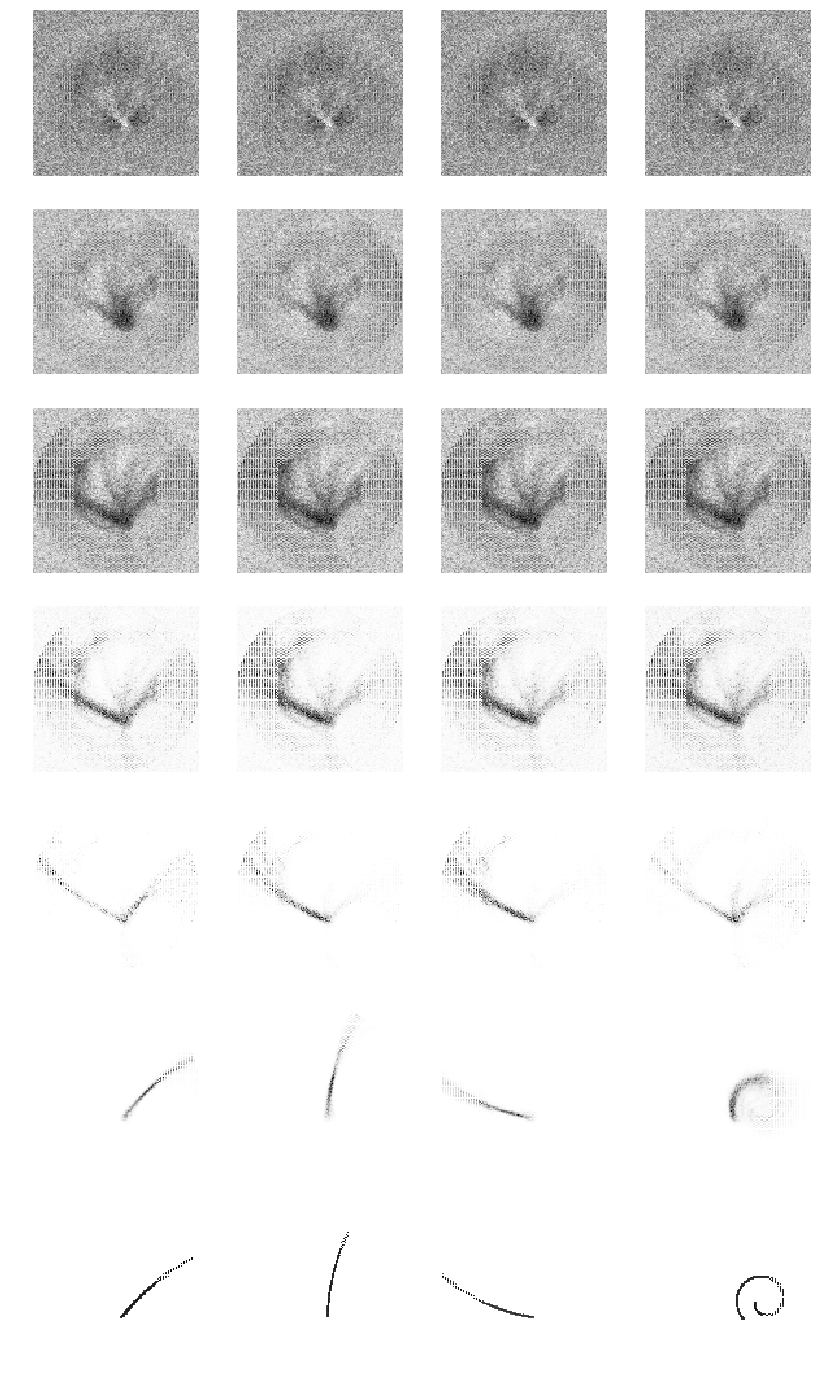

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=T+1, figsize=(14, 25))

for t in range(T):
    canvasses = reconstructions[t]
    [a.imshow(canvas, cmap="Greys") for a, canvas in zip(ax[t], canvasses)]
    [ax[t][i].axis("off")for i in range(4)]

[a.imshow(og_event, cmap="Greys") for a, og_event in zip(ax[-1], og_events)]
tmp = [ax[-1][i].axis("off")for i in range(4)]

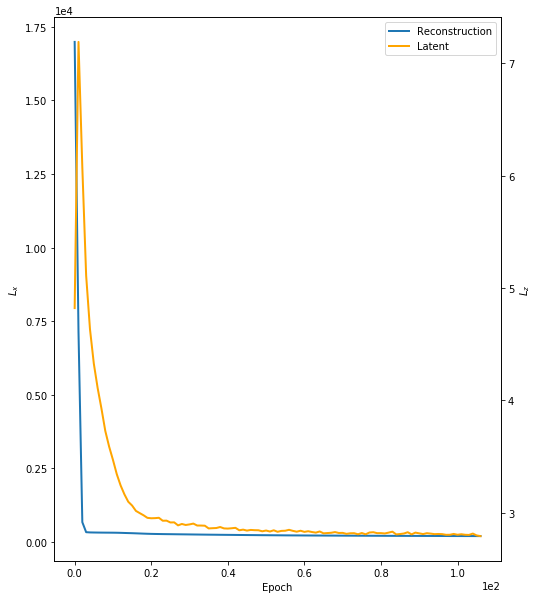

In [12]:
fig, ax = plt.subplots(figsize=(8, 10))
lx_run = lx[lx>0]
lz_run = lz[lz>0]
ax2 = ax.twinx()
l1 = ax.plot(np.arange(len(lx_run)), lx_run, label="Reconstruction", lw=2)
l2 = ax2.plot(np.arange(len(lx_run)), lz_run, c="orange", label="Latent", lw=2)
labels = l1+l2
ax.legend(labels, [l.get_label() for l in labels])
ax.set_xlabel("Epoch")
ax.set_ylabel(r"$L_x$")
ax2.set_ylabel(r"$L_z$")
ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
ax2.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))

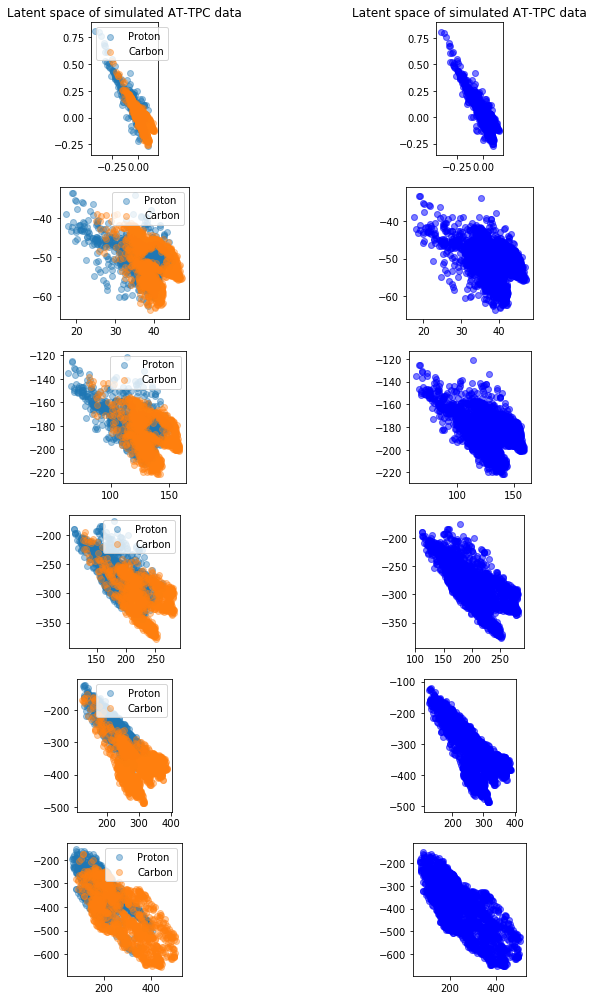

In [13]:
"""
Secondly we want to inspect the latent space to investigate if we can visually 
identify a clustering. We chose the latent dimension to be 2 to give an easy 
visualization. We observe that there is a very good class separation in the space.
"""
all_labeled = x_labeled.reshape((x_labeled.shape[0], -1))
latent_labeled = np.array(model.run_large(sess, model.z_seq, all_labeled))
#latent_labeled = TSNE(2).fit_transform(latent_labeled)
fig, ax = plt.subplots(figsize=(10, 14), ncols=2, nrows=T)
physics = ["Proton", "Carbon"]
mnist = ["{}".format(i) for i in range(len(np.unique(y)))]
classes = physics if len(np.unique(y)) == 2 else mnist


for t in range(T):
    for i in range(len(np.unique(y))):
        ax[t][1].scatter(latent_labeled[t][:,0], latent_labeled[t][:,1], alpha=0.3, c="b")
        class_samples = latent_labeled[t][y == i]
        ax[t][0].scatter(class_samples[:,0], class_samples[:,1], label=classes[i], alpha=0.4)
        if t == 0:
            ax[t][i].set_title("Latent space of simulated AT-TPC data")
        ax[t][i].set_aspect("equal")
        ax[t][0].legend(loc="best")

plt.tight_layout()